<a href="https://colab.research.google.com/github/DonnaVakalis/forecasting-MRT-gap/blob/main/models/XGBoost3__AirTemp_target.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with XGBoost model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). While this notebook contains only the first steps, ultimately it can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [1]:
# Install XGBoost
# ! pip install xgboost # this gives version 0.90
! pip install xgboost==1.4.2 # as of Sept 2021 this is most recent stable release


# import all the usual suspects :)
import os
from google.colab import drive
import pickle
 
import numpy as np
import pandas as pd
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sns

# Sci-kit learn packages for normalizing data and post-processing
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import median_absolute_error, mean_absolute_error, mean_squared_error, matthews_corrcoef, r2_score, accuracy_score
 
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# boosting libraries from XGBoost
import xgboost as xgb

print("XGBoost version:", xgb.__version__)

     |████████████████████████████████| 166.7 MB 18 kB/s 
  Attempting uninstall: xgboost
    Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
XGBoost version: 1.4.2


# LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

\n
... The notebook used to define the features and tune/train the model are available here: 

## Mount drive and define folders that hold the data files

In [2]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"
FIGURES_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/figures"

Mounted at /content/gdrive


## Upload files with pre-processed data and model

In [16]:
# Training/test set, Features (X variables) during occupied hours:
df_X = pickle.load(open(DATA_PATH + '/X_occHrs.p','rb'))
     
# Training/test set, Prediction Target (y variable) during occupied hours:
df_y = pickle.load(open(DATA_PATH + '/y_occHrs.p','rb'))


# Additionally, Prediciton Target during all hours (including unoccupied)
df_y_allHrs = pickle.load(open(DATA_PATH + '/y_allTimes.p', 'rb'))

# Forecasted Features (Features only, years 2020-2080): 
df_future = pickle.load(open(DATA_PATH + '/future_inputs.p','rb'))

# load XGBoost trained model:
model_fitted = pickle.load(open(DATA_PATH + '/fitted_xgb.p', "rb"))

## Array the data (i.e., convert to numpy arrays) for use by the model

In [4]:
# Convert features and target and time stamps to separate numpy arrays
x = df_X.copy().to_numpy()
y = df_y.copy().to_numpy().reshape(-1,1) # need to reshape Y which contains 1 features (currently it's 0) 
t = df_X.index.copy() # create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)

# NB this artificial split does something to the shape that the model requires (!!?)
x_, ignore_X, y_, ignore_y, time_stamp, ignore_t = train_test_split(x, y, t, shuffle = False, test_size= 0.00001)

# check
print("dimensions of features array, and Y:", x_.shape, y_.shape)
print("dimensions of time stamp for train and test sets:", time_stamp.shape)

dimensions of features array, and Y: (1247, 8) (1247, 1)
dimensions of time stamp for train and test sets: (1247,)


## MSE and Visually examine predicted indoor air temp against test set 

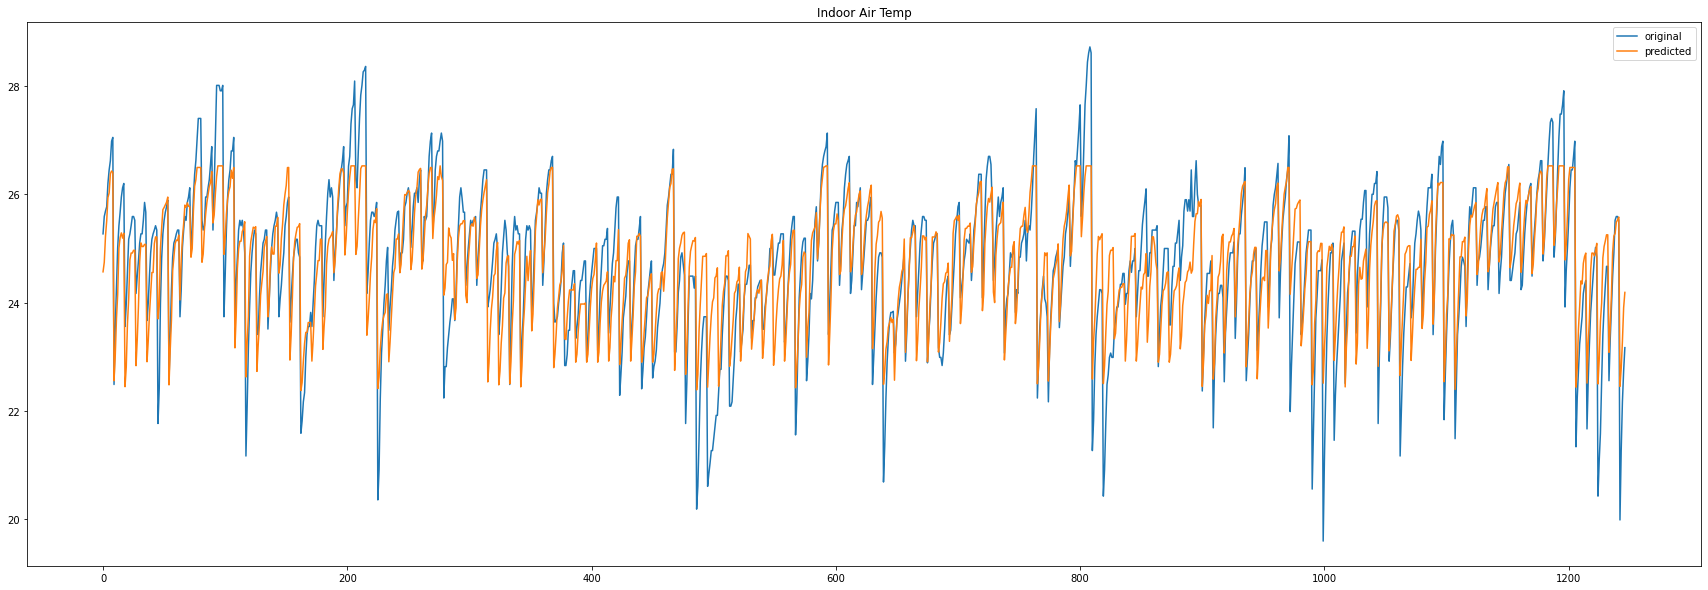

In [5]:
# Visualize Predictions of indoor air temp (using fitted model)
# Note: this is not a depiction of 'fit' because we trained on 85% of this data 
# for mean squared error and/or other measurements of fitness see training notebook

y_pred = model_fitted.predict(x_)

plt.figure(figsize=(30,10))
x_ax = range(len(y_pred))
plt.plot(x_ax, y_, label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Indoor Air Temp")

plt.legend()
plt.show()

#  USE PREDICTION (OR KNOWN INDOOR TEMP) ALONG WITH OUTDOOR TEMP TO CALCULATE DESIRED LOCAL MRT

###  Finding the (hourly) 'comfortable' operative temperature based on average outdoor air temperatures  

The adaptive comfort model's stipulated 'comfortable oeprative temperature' which is defined as a function of the average outdoor air temperature.

Tcomf = 0.31*[Ta,out] + 17.8

where: Tcomf = indoor comfortable temperature
Ta,out = mean outdoor air temperature*

*mean outdoor temperature as the input variable for the adaptive model. It is based on the arithmetic average of the mean daily outdoor temperatures over no fewer than 7 and no more than 30 sequential days prior. We will use 7.


sources:
ANSI/ASHRAE Standard 55-2017, Thermal Environmental Conditions for Human Occupancy. de Dear, R., & Brager, G. S. (2002). Thermal comfort in naturally ventilated buildings: revisions to ASHRAE Standard 55. Energy and Buildings, 34, 549-561.

In [6]:
def get_comfy_opTemperature (outdoor_air):

    # Calculate average of previous week's outdoor air temp (for calculating comfortable op temp)
    out_7dayAverage = outdoor_air.rolling(168, min_periods=72).mean() 

    # Calculate adaptive model comfort temp
    return 0.31*out_7dayAverage +17.8

### Use comfy threshold to find the (hourly) local MRT necessary given background indoor temps

The desired 'outcome' is whether the current hour is 'comfortable', based on comparing the indoor air temperature and the adaptive comfort model's stipulated 'comfortable oeprative temperature' (see previous block). 

GAP = op_temp_comfy - op_temp

where

op_temp = 0.5*(air_temp + MRT)

i.e., indoor operative temperature is an average of air temperature and mean radiant temperature, MRT

If the GAP is 0, then:

op_temp_comfy == op_temp

op_temp_comfy == 0.5*(air_temp + MRT)

And re-written to find what the gap is in terms of MRT:

MRT = 2*op_temp_comfy - air_temp

In [7]:
def get_required_MRT(comfy_operativeTemp,indoor_airTemp): 
    # this is the gap between indoor AIR temp and desired indoor OPERATIVE temp
    return 2*comfy_operativeTemp - indoor_airTemp

## Using above functions, calculate the MRT 
1. using each of the whole data, and then 
2. for the time period of just test set (i.e., known vs. prediction-based indoor temp)

In [9]:
y_pred

array([24.569225, 24.744312, 25.22162 , ..., 23.285917, 23.907047,
       24.189547], dtype=float32)

### 1. MRT based on the entire input set (ie. known outdoor and known indoor)

In [12]:
# We don't need all the features from the X set, just the outdoor temp! 
out_air = pd.Series(x_[:,0])

# Get the target variable (indoor temp)
ind_air = pd.Series(y_[:,0])  

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT = get_required_MRT(comfy_opTmp,ind_air)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_ = pd.DataFrame({'ind_air': ind_air, 
                   'out_air':out_air,
                   'comfy_opTmp': comfy_opTmp,
                   'comfy_MRT': comfy_MRT}).set_index(time_stamp) #recall t was the original date-time stamp df_all_X.index 

# Try adding don't want to plot as rows of NANs explicitly... to allow matplotlib to "mask" these instead of connecting
# Merge this dataframe that only has data for days/times during occupied hours, with the longer data-time index from  a longer df that has "all" the dates
df_all = df_Y_trgt.join(df_).drop('air_tmp_ind',1) # This fills in missing rows explicitly with NaNs
 

def visualize_given_year(dat=df_all.copy(), year=2015):
    yr = year

    df_plot = dat.copy()

    # keep only summer dates, e.g., June, July and August:
    df_yr = df_plot[df_plot.index.month.isin([6,7,8]) & (df_plot.index.year == yr)]

    # Plot it
    plt.figure(figsize=(30,5))
    
    x_ax = df_yr.index
    plt.plot(x_ax, df_yr.ind_air, label="air temperature", linestyle='', marker=',')
    plt.plot(x_ax, df_yr.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
    plt.plot(x_ax, df_yr.comfy_MRT, label="required MRT", linestyle='-', marker='.')
    plt.title("Looking at required MRT given hourly indoor conditions during the summer of %i" %yr)
    plt.legend()
    plt.show()

# Visualize 2015
visualize_given_year(df_all, 2015)

# Visualize 2016
visualize_given_year(df_all, 2016)

# Visualize 2017
visualize_given_year(df_all, 2017)

NameError: ignored

### 2. MRT based on test set (ie. compared known to predicted indoor)

In [11]:
# Set the outdoor air, restrict to test set this time
out_air = pd.Series(testX[:,0]) # we just need column with outdoor temp! 

# First change the size of the array of prediciton to match the array of the test
y_pred = y_pred.reshape(-1,1)

# Get the target variable (indoor temp) either 'real' or predicted
ind_air_known = pd.Series(testY[:,0]) # test set of real indoor temp
ind_air_pred = pd.Series(y_pred[:,0]) # for same times, predicted indoor temps 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT_known = get_required_MRT(comfy_opTmp,ind_air_known)
comfy_MRT_pred = get_required_MRT(comfy_opTmp,ind_air_pred)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp (predicted or real), Comfortable Target Operative Temp, Required MRT 
df_all_2 = pd.DataFrame({'ind_air': ind_air_known, 
                       'ind_air_predicted': ind_air_pred,
                        'out_air':out_air,
                        'comfy_opTmp': comfy_opTmp,
                        'comfy_MRT': comfy_MRT_known,
                        'comfy_MRT_pred': comfy_MRT_pred}).set_index(testTime) #recall t was the original date-time stamp df_all_X.index 

                        

NameError: ignored

In [ ]:
df_plot = df_all_2.copy()

plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.ind_air, label="indoor air temperature", linestyle='-', marker='')
plt.plot(x_ax, df_plot.ind_air_predicted, label="predicted indoor air temperature", linestyle='-', marker='')
plt.title("Recorded versus predicted indoor temperature")
plt.legend()
plt.show()


plt.figure(figsize=(30,5))
x_ax = df_plot.index

plt.plot(x_ax, df_plot.ind_air, label="air temperature", linestyle=' ', marker=',')
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker=',')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on recorded indoor temp", linestyle='', marker='')
plt.plot(x_ax, df_plot.comfy_MRT_pred, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show()

## How did the prediction-based MRT perform relative to the known-temp-based MRT? Specifically, we care about the performance during occupied hours... (and peaks along with dewpoint, more than hour-by-hour accuracy).

In [ ]:
# Compare times of day when occupied to see 'how good' the prediction is...
df_daytime = df_all_2[df_all_2.index.hour.isin(range(9,17))] # Filter by time of day on df_all_2 which holds the results of text x, test y and predicted Y, along with MRT. 

#Visualize occupied hours only
df_plot=df_daytime.copy()
x_ax = df_plot.index

plt.figure(figsize=(30,5))
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on recorded indoor temp", linestyle='', marker='.')
plt.plot(x_ax, df_plot.comfy_MRT_pred, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show() # looks like our model is biased to underestimate needed MRT... 

# alternative to above plot.. #graphically white-out spans of unoccupied times? 
# see fill bewteen two vertical lines https://stackoverflow.com/questions/23248435/fill-between-two-vertical-lines-in-matplotlib
# ax.axvspan(8, 14, alpha=0.5, color='red')

# For another look: directly plot the difference between MRT based on prediction and recorded  
df_plot['diff_air'] = df_plot['ind_air_predicted'] - df_plot['ind_air']
df_plot['diff_MRT'] = df_plot['comfy_MRT_pred'] - df_plot['comfy_MRT']

model1_sum_of_diff_MRT = df_plot['diff_MRT'].abs().sum()
model1_mean_diff_MRT = df_plot['diff_MRT'].mean()

plt.figure(figsize=(15,5))
plt.bar(x_ax, df_plot.diff_air, label="Difference between prediction and recorded indoor air temp")
#plt.bar(x_ax, df_plot.diff_MRT, label="Resulting difference between prediction-based and record-based MRT to stay comfortable")
plt.title("Difference between predicted and measured in test set (positive means predicted is higher)")
plt.legend()
plt.show() 
 
p1 = sns.displot(df_plot.diff_air, bins=60, kde=True)
p1.set( xlabel = "Delta: Air temp prediction - Air temp recorded ", ylabel = "Hours", title="Air Temp prediction versus 'real'")

p2 = sns.displot(df_plot.diff_MRT, bins=60, kde=True)
p2.set( xlabel = "Delta: Prediction-based MRT - recorded temp-based MRT", ylabel = "Hours", title="MRT prediction versus 'real'")


In [ ]:
# looks like our model is biased to underestimate temp and thus overestimate cooling needed 

# If we group by day of the week, does the amount of cooling undershoot or overshoot and by how much? 

sns.set_context('paper')
df_long = df_plot[['diff_air','diff_MRT']].reset_index().melt(id_vars='index', var_name='air_or_MRT', value_name='degrees').rename(columns={'index':'time_stamp'})
df_long['day'] = df_long['time_stamp'].dt.day_name()

sns.barplot(x = 'air_or_MRT', y = 'degrees',  data = df_long,
            hue ='day',
            palette = 'Blues', edgecolor = 'w')
df_long.groupby(['day','air_or_MRT']).mean()
plt.show()

# FUTURE PROJECTIONS

### Load data into dataframes and create features to match training set

Should match the columns of training set: e.g., df_X_occHrs

features:  ['temp' 'last_temp_2' 'last_temp_4' 'temp_ave_48hr'
 'temp_max_24hr' 'temp_min_24hr' 'day_cos' 'day_sin']

## Predictions for 2023 to 2080

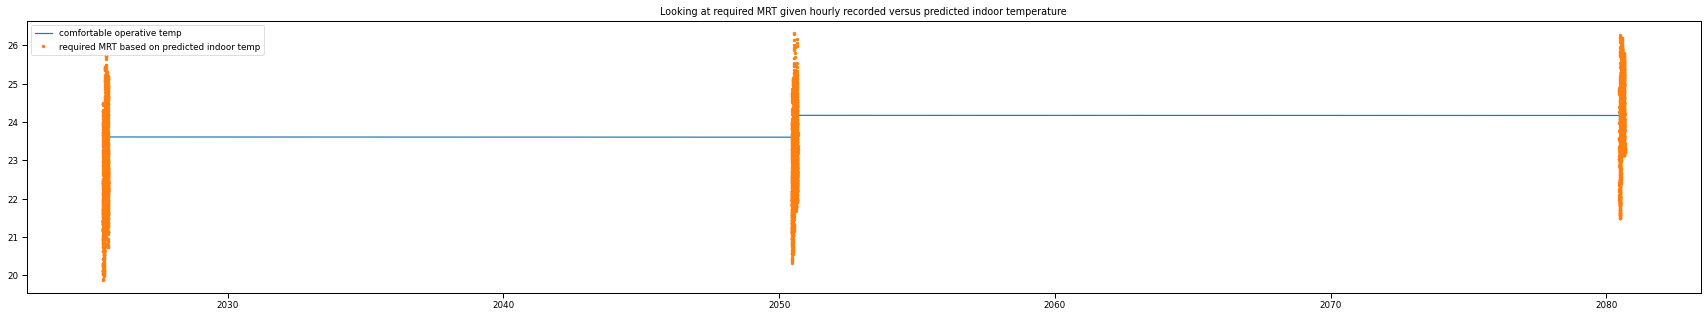

In [ ]:
# 2023- 2080
# work with data set that goes to 2080
X_to_2080 = ftr_X_summrHrs.copy()

# Cut years before 2023
remove_before = pd.to_datetime('2023-06-01') #*keep last week of May (if available) for lag time
X_2023_80 = X_to_2080.query('index >= @remove_before')


x = X_2023_80.to_numpy()
t = X_2023_80.index.copy() # create an array to hold the date-time stamp (will rejoin it later for distinguishing occupied/unoccupied times)

# Extra step to reformat in a way that doesn't throw an error inside the model's prediction function
x_all, testX, time_all, testTime = train_test_split(x, t, shuffle = False, test_size= 0.0001)

# Prediction 2025
pred_2025 = model2.predict(x_all)

# Calculate MRT to achieve comfortable operating temp

# Set the outdoor air 
out_air = pd.Series(x_all[:,0])  

# First change the size of the array of prediciton to match the array of the test
y_pred = pred_2025.reshape(-1,1)

# Get predicted indoor temp
ind_air_pred = pd.Series(y_pred[:,0]) # for same times, predicted indoor temps 

comfy_opTmp = get_comfy_opTemperature(out_air)

comfy_MRT_pred = get_required_MRT(comfy_opTmp,ind_air_pred)

# Save a dataframe to hold: Date-Time, Outdoor Air Temp, Indoor Air Temp, Comfortable Target Operative Temp, Required MRT 
df_all_ftr = pd.DataFrame({'ind_air_predicted': ind_air_pred,
                        'out_air':out_air,
                        'comfy_opTmp': comfy_opTmp,
                        'comfy_MRT': comfy_MRT_pred}).set_index(time_all) #recall t was the original date-time stamp df_all_X.index 

# PLOTS
df_plot = df_all_ftr.copy()
x_ax = df_plot.index

# Visualize Each of 2025, 2050 and 2080 on subplots:
plt.figure(figsize=(30,5))
plt.plot(x_ax, df_plot.comfy_opTmp, label="comfortable operative temp",linestyle='-', marker='')
plt.plot(x_ax, df_plot.comfy_MRT, label="required MRT based on predicted indoor temp", linestyle='', marker='.')
plt.title("Looking at required MRT given hourly recorded versus predicted indoor temperature")
plt.legend()
plt.show() 

## TO DO:



*   Quantify degree-hours that exceed comfort threshold during the summer, during occupied building hours, without any intervention. For each year (e.g., in recorded years, and in future years). 
*    Quantify what background MRT 'needs to be' (i.e., our model calc) to keep things comfortable... furthermore, how often (and when) this drops below the estimated dew point (in recorded years and in future years).
*   More detailed analysis: if we have scenarios where panels account for X% of view factor (and 'background MRT' is 1-X%), then what does the panel MRT need to be? AND how often (and when) does the MEMBRANE drop below the estimated dew point? 
*    AND how much energy would it take to keep occupants comfy PER OCCUPANT and TOTAL? (how 

* Ultimately, metric to calculate: % of comfortable hours as a function of view factor, year, climate change 
* Could we estimate the error of this 'end-to-end' prediction? Where is the error largest? (e.g., model of outdoor-indoor, weather inputs of future climate versus comfort model versus inherennt VF?) 

 check wheather we really want weather: https://www.weathershift.com/purchase/
 https://services.pacificclimate.org/wx-files/app/

 check adaptive method model at https://comfort.cbe.berkeley.edu








Approximation of actual background MRT (as different from desired background to maintain comfortable conditions)#

Notes
 approximation of dew point temperature if you know the observed temperature and relative humidity

Td = T - ((100 - RH)/5.)

where Td is dew point temperature (in degrees Celsius), T is observed temperature (in degrees Celsius), and RH is relative humidity (in percent). Apparently this relationship is fairly accurate for relative humidity values above 50%.

More details can be found in the article:

Lawrence, Mark G., 2005: The relationship between relative humidity and the dewpoint temperature in moist air: A simple conversion and applications. Bull. Amer. Meteor. Soc., 86, 225-233. doi: http;//dx.doi.org/10.1175/BAMS-86-2-225


Next steps#
Run with future outdoor air temps on same building.
Run with this summer's air temps? 

In parallel: how to quantify and best communicate level of 'error' and level of 'uncertainty' 